In [90]:
import numpy as np
from math import sqrt, exp, log, floor
from functools import partial
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline

def data_converged(theta_prime, theta, p, tol):
    #return all([ abs(theta_prime[i] - theta[i]) < tol for i in range(p) ])
    return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol

# dJ: gradient of J
# alpha: learning rate
# tol: tolerance
# init_theta: vector of inital values for theta
# max_num_rounds: max iterations of the algorithm
# x_data: x data points
# y_data: y data points
def batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data):
    p = len(dJ)
    assert(p == len(init_theta))
    assert(p == np.array(x_data).shape[1])
    assert(len(x_data) == len(y_data))
    
    theta = init_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = [theta[i] - alpha * dJ[i](theta, x_data, y_data) for i in range(p)]
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
            
    return theta

def standardize(data):
    d_mean = np.mean(data)
    d_stddev = np.std(data, ddof=1)
    if d_stddev == 0:
        return data
    return [ (d-d_mean)/d_stddev for d in data ]

In [91]:
def dotp(x1, x2):
    return sum([x1i*x2i for (x1i,x2i) in zip(x1,x2)])

def dtheta_di_lasso(lam, i, q, theta, x_data, y_data):
    accum = 0.0
    for (xj,yj) in zip(x_data,y_data):
        xji = xj[i]
        accum += -2 * xji * (yj - dotp(theta,xj)) + lam*(abs(theta[i]) ** q)/theta[i]
    return accum
    #return np.power([accum], [1.0/q])[0]

def lasso_gd(lam, x_data, y_data, q=1):
    p = np.array(x_data).shape[1]
    alpha = 0.0001
    tol = 0.0001
    #init_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    init_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 100
    dJ = [ partial(dtheta_di_lasso, lam, i, q) for i in range(p) ]
    return batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data)

In [92]:
def nej(j, e, k):
    return 0 if k == j else e

def yij_tilde(xi, theta, j):
    return sum([ nej(j, xi[k]*theta[k], k) for k in range(len(theta)) ])

def soft_thresh(a):
    return max(a, 0)

def sign(a):
    # we can define sign(0) = 1 without any harm here because of the assert on lam in S and Sq
    return 1 if a >= 0 else -1
    
def S(t, lam):
    assert(lam >= 0)
    return sign(t)*soft_thresh(abs(t) - lam)

def lasso_cd(lam, x_data, y_data, intercept=False):
    n = len(x_data)
    p = len(x_data[0])
    assert(lam >= 0)
    assert(n >= 2)
    #initial_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    initial_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 1000
    tol = 0.0001
    
    theta = initial_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = theta.copy()
        for j in range(p):
            if intercept and j == 0:
                # intercepts don't really work right now
                theta_prime[j] = sum([ xi[j]*(yi - yij_tilde(xi,theta_prime,j))
                                          for (xi,yi) in zip(x_data,y_data) ]) / (n-1)
            else:
                theta_prime[j] = S( sum([ xi[j]*(yi - yij_tilde(xi,theta_prime,j))
                                          for (xi,yi) in zip(x_data,y_data) ]) / (n-1),
                                    lam)
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
        
    return theta

def Sq(t, lam, q):
    assert(lam >= 0)
    signp = max(floor(q), 1) # may not be what we want
    return (sign(t)**signp)*soft_thresh(abs(t)**q - lam)

def lasso_cd_q(lam, x_data, y_data, q):
    assert(lam >= 0)
    n = len(x_data)
    p = len(x_data[0])
    initial_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 1000
    tol = 0.0001
    
    theta = initial_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = theta.copy()
        for j in range(p):
            theta_prime[j] = Sq( sum([ xi[j]*(yi - yij_tilde(xi,theta_prime,j))
                                          for (xi,yi) in zip(x_data,y_data) ]) / (n-1),
                                    lam, q)
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
        
    return theta


In [93]:
def elastic_net_pathwise_cd(alpha, lam, x_data, y_data):
    n = len(x_data)
    p = len(x_data[0])
    assert(0. <= alpha <= 1.)
    assert(lam >= 0)
    assert(n >= 2)
    initial_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 1000
    tol = 0.0001
    
    A = (n-1) + 2*lam*alpha
    B = lam*(1-alpha)
    theta = initial_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = theta.copy()
        for j in range(p):
            theta_prime[j] = S( sum([ xi[j]*(yi - yij_tilde(xi,theta_prime,j))
                                      for (xi,yi) in zip(x_data,y_data) ]) / A,
                                B)
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
        
    return theta

In [94]:
def unif_simulation(a, b, N=1):
    return np.random.uniform(a, b, N)

def normal_simulation(mean, stddev, N):
    return np.random.normal(mean, stddev, N)

def e():
    return normal_simulation(0, np.sqrt(4), 1)[0]
    
def e_err():
    if unif_simulation(1,100) <= 10:
        if unif_simulation(1,2) == 1:
            return normal_simulation(0, np.sqrt(4), 1)[0] + 5
        else:
            return normal_simulation(0, np.sqrt(4), 1)[0] - 5
    else:
        return normal_simulation(0, np.sqrt(4), 1)[0]

def Y(f, x):
    return f(x) + e()

# creates a (n x p) design matrix
def create_design_mat(x_data, max_order):
    data = []
    for order in range(max_order + 1):
        data.append(standardize([d ** order for d in x_data]))
    return np.array(data).T

def calc_yhat(theta, x):
    max_order = len(theta)
    xvals = [x ** order for order in range(max_order+1)]
    return sum([theta_i*x_i for (theta_i,x_i) in zip(theta,xvals)])


In [95]:
colors = ['blue', 'green', 'brown', 'purple', 'yellow', 'lawngreen', 'darkblue', 'olive', 'greenyellow', 'silver']

def mse(y, y_hat):
    n = len(y)
    assert(n == len(y_hat))
    return sum([ (yi-yi_hat)**2 for (yi,yi_hat) in zip(y,y_hat) ]) / n

def plt_lasso_mse(algo, q, lams, design, y_data, title=None):
    p = len(design[0])
    thetas = [ algo(lam, design, y_data, q) for lam in lams ]
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    coeffs, mses = axes.flatten()
    
    for i in range(p):
        theta_is = [ theta[i] for theta in thetas ]
        coeffs.plot(lams, theta_is, color=colors[i], label=i)
    
    lam_mses = [ mse(y_data, [dotp(theta, nd) for nd in design]) for theta in thetas ]
    mses.plot(lams, lam_mses, color='b')
        
    if title == None:
        title = "q={}".format(q)
    plt.title(title)
    coeffs.legend()
    plt.show()

def plt_lasso(algo, q, lams, design, y_data, title=None):
    p = len(design[0])
    thetas = [ algo(lam, design, y_data, q) for lam in lams ]
    
    for i in range(p):
        theta_is = [ theta[i] for theta in thetas ]
        plt.plot(lams, theta_is, color=colors[i], label=i)
    if title == None:
        title = "q={}".format(q)
    plt.title(title)
    plt.legend()
    plt.show()

In [96]:
f = lambda x: x + x**3
p = 6
x_data = unif_simulation(-2, 2, 40) #200)
y_data = standardize([Y(f, x) for x in x_data])
design = create_design_mat(x_data, p)

dest = 1
n = 20
lams = [ dest*i/n for i in range(n) ]

#for q in [0.5, 1, 2, 4]:
    #plt_lasso(lasso_cd_q, q, lams, design, y_data)

Optimal Validation MSE: 0.19374338008136116
Corresponding Lambda Value: 0.03333333333333333


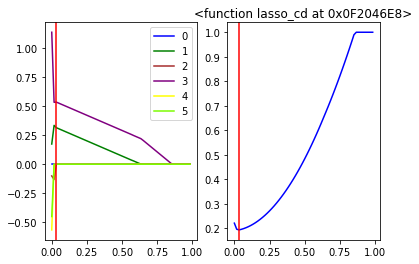

Optimal Validation MSE: 0.21442107238300606
Corresponding Lambda Value: 0.016666666666666666


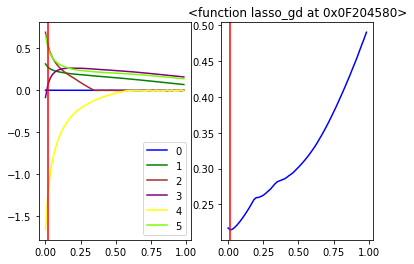

In [97]:

# generate a single data set and train a model using the given algorithm
def train(algo, lam, f, p, N):
    x_data = unif_simulation(-2, 2, N)
    y_data = standardize([Y(f, x) for x in x_data])
    design = create_design_mat(x_data, p)
    return algo(lam, design, y_data)

def validate(y_data, design, model):
    y_hats = [ dotp(model,xi) for xi in design ]
    return mse(y_data, y_hats)

def train_and_validate(algo, lams, f, p):
    N = 50
    M = 5000
    
    x_data_train = unif_simulation(-2, 2, N)
    y_data_train = standardize([Y(f, x) for x in x_data_train])
    design_train = create_design_mat(x_data_train, p)
    models = [ algo(lam, design_train, y_data_train) for lam in lams ]
    
    x_data_valid = unif_simulation(-2, 2, M)
    y_data_valid = standardize([Y(f, x) for x in x_data_valid])
    design_valid = create_design_mat(x_data_valid, p)
    validation_mses = [ validate(y_data_valid, design_valid, model) for model in models ]
    min_mse_idx = np.argmin(validation_mses)
    print("Optimal Validation MSE: {}".format(validation_mses[min_mse_idx]))
    print("Corresponding Lambda Value: {}".format(lams[min_mse_idx]))
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    coeffs, mses = axes.flatten()
    
    for i in range(p):
        theta_is = [ theta[i] for theta in models ]
        coeffs.plot(lams, theta_is, color=colors[i], label=i)
    coeffs.axvline(x=lams[min_mse_idx], color='r')
    coeffs.legend()
    mses.plot(lams, validation_mses, color='b')
    mses.axvline(x=lams[min_mse_idx], color='r')
    plt.title(algo)
    plt.show()
    
    
np.random.seed(7) #4543)
f = lambda x: x + x**3
p = 6
dest = 1
n = 60
lams = [ dest*i/n for i in range(n) ]

for algo in [lasso_cd, lasso_gd]:
    train_and_validate(algo, lams, f, p)

Optimal Validation MSE: 0.19475903842056527
Corresponding Lambda Value: 0.016666666666666666


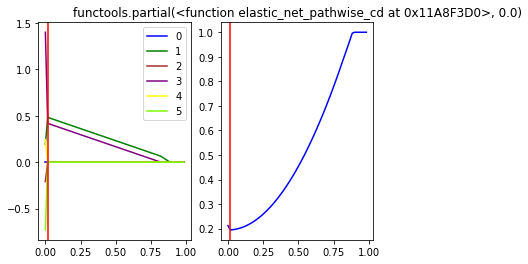

Optimal Validation MSE: 0.19850139164843408
Corresponding Lambda Value: 0.06666666666666667


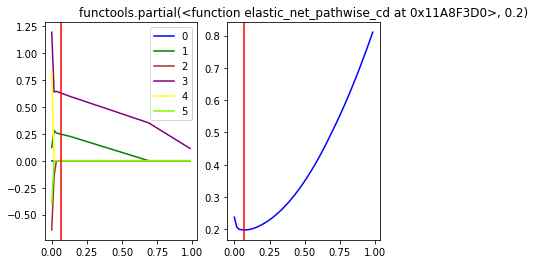

Optimal Validation MSE: 0.19274718126349566
Corresponding Lambda Value: 0.016666666666666666


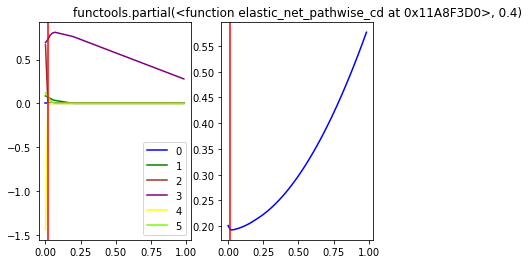

Optimal Validation MSE: 0.20427987332516717
Corresponding Lambda Value: 0.016666666666666666


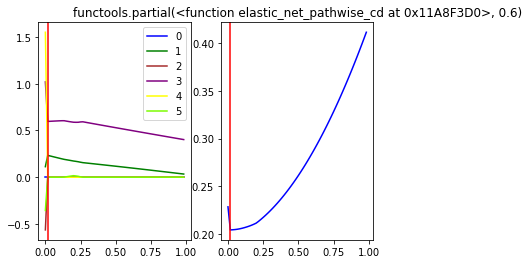

Optimal Validation MSE: 0.20088408131872312
Corresponding Lambda Value: 0.11666666666666667


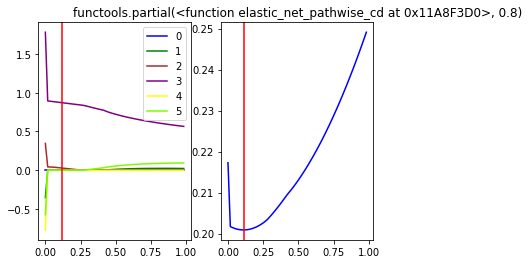

Optimal Validation MSE: 0.20546028491144167
Corresponding Lambda Value: 0.9833333333333333


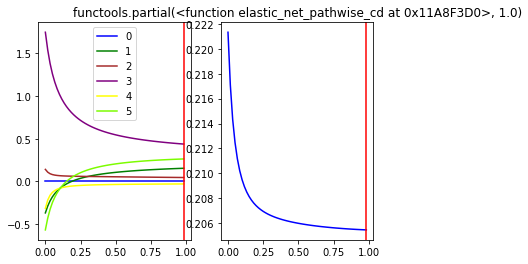

In [98]:
#np.random.seed(7)

def cen(alpha):
    return partial(elastic_net_pathwise_cd, alpha)

f = lambda x: x + x**3
p = 6
dest = 1
n = 60
lams = [ dest*i/n for i in range(n) ]

opts = 5
en_opts = [ cen(i/opts) for i in range(opts+1) ]
for algo in en_opts:
    train_and_validate(algo, lams, f, p)